In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import copy
from sklearn import preprocessing
from comut import comut
import palettable as pal
from statsmodels.stats.multitest import multipletests
import seaborn as sns
from scipy.stats import ranksums
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../utility_code/')


plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

import utils as utils
import general_utils as gen_utils

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

In [3]:
'''
colors
'''

variantC = pal.wesanderson.Moonrise6_5.mpl_colors
clinC = pal.cartocolors.qualitative.Vivid_10.mpl_colors

mappings={}
variants = ['Frame_Shift_Ins', 'Frame_Shift_Del', 'Nonsense_Mutation', 'Missense_Mutation', 'Splice_Site']
mappings['variant'] = {
    'Subclonal': {'facecolor':'none', 'edgecolor':'gainsboro', 'linewidth': 4},
    'Silent':'#FFD700',
    'Absent': {'facecolor': 'gainsboro'},
    'LOH':{'facecolor':clinC[4], 'edgecolor':'black'},
    'cn_del': {'facecolor':'dodgerblue', 'edgecolor':'black'}, 'cn_amp':{'facecolor':'tab:red', 'edgecolor':'black'}, 'Other':'black',
    'Missense_Mutation (GoF)':{'facecolor':'purple', 'edgecolor':'black'},
}
mappings['variant'] = mappings['variant'] | {variants[q] : {'facecolor':variantC[q], 'edgecolor':'black'} for q in range(len(variants))}

bar_kwargs = {'width': 0.8, 'edgecolor': 'black'}

clinvars = ['Positive', 'No Response', 'MHC-Intact', 'Negative', 'MHC-LOH', 'Response', 'No Prior IO', 'Prior IO', 'History Of Smoking', 'No History Of Smoking']
mappings['clinical'] = {clinvars[q]:{'facecolor':clinC[q], 'edgecolor':'black'} for q in range(len(clinvars))} | {'Not Assessed':{'facecolor': 'gainsboro'}}
mappings['clinical']['Response'] = {'facecolor':'tab:green', 'edgecolor':'black'}
mappings['clinical'] = mappings['clinical'] | {'Cohort A': {'facecolor':'lightseagreen', 'edgecolor':'black'}, 'Cohort 2L+': {'facecolor':'lightseagreen', 'edgecolor':'black'}, 
                                               'Cohort B': {'facecolor':'crimson', 'edgecolor':'black'}, 'Cohort 1L': {'facecolor':'crimson', 'edgecolor':'black'}}

mappings['side'] = {'p_val': 'darkgrey', 'qval': 'darkgrey', 'fdr':'darkgrey', '-log(q)':'darkgrey'}
mappings['Pdl1 Cps'] = {'PDL1_CPS >=20': {'facecolor':'olive', 'edgecolor':'black'}, 
                        'PDL1_CPS 1-19': {'facecolor':'darkkhaki', 'edgecolor':'black'}, 
                        'PDL1_CPS < 1': {'facecolor':'khaki', 'edgecolor':'black'}, 
                        np.nan:{'facecolor': 'grey', 'alpha': 0.2}}

In [4]:
'''
loading maf file
'''

maf_file = '../data/final_pairs.aggregated.tsv'
df_maf = pd.read_csv(maf_file, sep='\t')

'''
loading oncokb maf
'''

oncokb_maf_f = '../data/final_pairs.oncokb_annotated.tsv'
Onco = pd.read_csv(oncokb_maf_f, sep='\t', encoding='ISO-8859-1', on_bad_lines='warn')

df_maf.head()

,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_position,End_position,Strand,Variant_Classification,Variant_Type,...,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1
0,HES4,57801,__UNKNOWN__,__UNKNOWN__,1,934642,934642,__UNKNOWN__,Missense_Mutation,SNP,...,3.395370e-03,5.940840e-03,1.031617e-02,1.778048e-02,3.042042e-02,5.166841e-02,8.712929e-02,1.458888e-01,2.425698e-01,4.005408e-01
1,TTLL10,254173,__UNKNOWN__,__UNKNOWN__,1,1132076,1132076,__UNKNOWN__,Silent,SNP,...,9.048886e-07,7.335382e-07,5.940073e-07,4.805133e-07,3.882990e-07,3.134564e-07,2.527787e-07,2.036380e-07,1.638833e-07,1.317558e-07
2,UBE4B,10277,__UNKNOWN__,__UNKNOWN__,1,10221176,10221177,__UNKNOWN__,Intron,DEL,...,4.229039e-02,4.435534e-02,4.637934e-02,4.835015e-02,5.025569e-02,5.208415e-02,5.382417e-02,5.546490e-02,5.699615e-02,5.840848e-02
3,SPEN,23013,__UNKNOWN__,__UNKNOWN__,1,16265253,16265253,__UNKNOWN__,Missense_Mutation,SNP,...,8.011349e-03,7.141352e-03,6.340049e-03,5.606162e-03,4.937671e-03,4.331955e-03,3.785928e-03,3.296157e-03,2.858978e-03,2.470588e-03
4,TIE1,7075,__UNKNOWN__,__UNKNOWN__,1,43773582,43773582,__UNKNOWN__,Missense_Mutation,SNP,...,2.813311e-02,3.540653e-02,4.436996e-02,5.536863e-02,6.880752e-02,8.515940e-02,1.049737e-01,1.288860e-01,1.576280e-01,1.920383e-01


In [5]:
'''
filtering maf, but keeping clonal mutations
'''

comut_maf = df_maf[['sample', 'Hugo_Symbol', 'Variant_Classification', 'ccf_hat', 'Start_position']]

comut_maf = comut_maf[comut_maf['Variant_Classification'].isin(["Missense_Mutation","Nonsense_Mutation","Splice_Site",
                                                            "Nonstop_Mutation","Frame_Shift_Ins","Frame_Shift_Del", 
                                                            "De_novo_Start_InFrame","Start_Codon_SNP", "In_Frame_Del",
                                                            "In_Frame_Ins","De_novo_Start_OutOfFrame","Start_Codon_Del",
                                                            "Stop_Codon_Del", 'Nonstop_Mutation', 'Stop_Codon_Ins'])]

comut_maf.rename(columns = {'Hugo_Symbol':'category', 'Variant_Classification':'value'}, inplace=True)

In [6]:
'''
loading focal cnv data
'''
event_types = ['amp'] # only doing amps because we now have biallelic deletion data
dfs={}

for i in event_types:
    dfs[i]=pd.read_csv(f"../data/truth_table_focal_{i}.csv")

df_cnv = pd.concat([utils.truth_table_to_comut_data(dfs[q], q) for q in event_types])
df_cnv['value'] = df_cnv['value'].str.replace('amp', 'cn_amp').str.replace('del', 'cn_del')

#including biallelic deletions
bidels = pd.read_csv('../data/gene_biallelic_deletion.tsv', sep='\t')
df_bidels = utils.truth_table_to_comut_data(bidels, 'cn_del')
df_cnv = pd.concat([df_cnv, df_bidels], ignore_index=True)
df_cnv['sample'] = df_cnv['sample'].str.split('-EXP').str[0]

'''
grabbing gene data
'''

gene_data = pd.read_excel('../data/gene_data.xlsx')
gene_data = gene_data[gene_data['pathway']!='MHC-II'].reset_index()
gene_data = gene_data.iloc[::-1]
gene_data = gene_data.reset_index()
gene_data = gene_data.drop(columns=['level_0', 'index'])
genes = list(gene_data['gene'])

'''
loading loh data
'''

loh = pd.read_csv('../data/loh_table.tsv', sep='\t', index_col=0)
df_loh = utils.truth_table_to_comut_data(loh, 'LOH')
df_loh = df_loh[df_loh['category'].isin(gene_data[gene_data['LOH']=='yes']['gene'].to_list())]
df_loh.loc[df_loh['sample'].str.contains('EXP'), 'sample'] = df_loh.loc[df_loh['sample'].str.contains('EXP')]['sample'].str.split('-E').str[0]

# df_loh.loc[:, 'category'] = 'HLA' #switching to one major category for HLA-A, B and C

In [7]:
'''
combine maf, cnv, and loh data together, then add annotations
'''

data = pd.concat([df_cnv, comut_maf, df_loh], ignore_index=True)

df_annot = pd.read_csv('../data/sample_annotations.tsv', sep='\t')
df_annot['cohort_sorting'] = df_annot['cohort'].map({'cohort A':2, 'cohort B':1})
df_annot['cohort'] = df_annot['cohort'].map({'cohort A':'Cohort 2L+', 'cohort B':'Cohort 1L'})

df_annot.columns = df_annot.columns.str.replace('_', ' ').str.title().str.replace('Sample', 'sample').str.replace('Hpv', 'HPV')
for cat in ['Cohort', 'Smoking Status']:
    df_annot[cat] = df_annot[cat].str.title()

# renaming HPV to p16
df_annot['p16 Status'] = df_annot['HPV Status']

data = data.merge(df_annot, on='sample', how='left')
data['sample_id'] = data['sample']
data['sample'] = data['Analysis Id']
data = data[data['Participant']!='MCC075'] # excluding from analysis due to lack of time on treatment


'''
replace nan and unknown values with Not Assessed
'''

for cat in ['Treatment Response', 'Prior Therapy', 'HPV Status', 'Smoking Status', 'Pdl1 Cps', 'Cohort']:
    data[cat] = data[cat].replace(dict.fromkeys([np.nan, 'Unknown'], 'Not Assessed'))

'''
grabbing pre-treatment samples
'''

T = pd.read_csv('../data/Chung_Head-Neck-treatments_2-5-2025.txt', sep='\t', comment='#')
T = T.sort_values(by=['participant_id', 'start_date_dfd'])
T = T.drop_duplicates(subset=['participant_id'], keep='last') #removing earlier treatments

M = data.merge(T[['participant_id', 'start_date_dfd']], left_on='Participant', right_on='participant_id', how='left')
M = M[((M['Collection Date Dfd']<=M['start_date_dfd'])|
       (M['Indicator'].isin(['C1D1', 'S', 'tiss']))|
       (M['Indicator'].str.contains('early')))].dropna(subset='sample')

# excluding participants that stopped treatment due to toxicity
text = pd.read_csv('../data/MCC19178_BOR_AE.txt', names=['column'])
text['num'] = text['column'].str[-3:]
toxicities = text.loc[17:20, 'num'].to_list()

M['num'] = M['participant_id'].str[-3:]
# M = M[~M['num'].isin(toxicities)]

comut_samples = list(M['sample'].unique())
comut_parts = list(M['Participant Analysis Id'].unique())

'''
creating treatment length bar data and adding to df
'''
part_A = pd.read_csv('../data/participant_annotations.tsv', sep='\t')

df_time = T.merge(part_A, left_on='participant_id', right_on='participant', how='left')
df_time['Treatment Length'] = df_time['stop_date_dfd'] - df_time['start_date_dfd']
df_time = df_time[['analysis_id', 'Treatment Length']].rename(columns={'analysis_id':'Participant Analysis Id'})

data = data.merge(df_time, on='Participant Analysis Id', how='left')

df_time = df_time.rename(columns={'Participant Analysis Id':'sample'})


'''
sort data
'''

data = data.sort_values(by=['Cohort Sorting', 'HPV Status', 'Treatment Length'], ascending=True)

In [8]:
'''
creating subclonal annotations
'''

df_clonal = data[(data['category'].isin(genes))&(data['ccf_hat']<.75)][['sample', 'category', 'value', 'Participant Analysis Id']]

df_clonal.loc[:, 'value'] = 'Subclonal'

'''
creating dataframe for plotting and adding oncokb annotations
'''
plot_df = data[data['sample'].isin(comut_samples)]

# merging with oncokb data
O = Onco[['Tumor_Sample_Barcode', 'Hugo_Symbol', 'Start_position', 'MUTATION_EFFECT']].copy()
O = O.rename(columns={'Tumor_Sample_Barcode':'sample_id', 'Hugo_Symbol':'category'})

plot_df = plot_df.merge(O, on=['sample_id', 'category', 'Start_position'], how='left')

'''
dropping unneeded events
'''

cn_genes = list(gene_data[gene_data['including_cnvs']=='yes']['gene'])
drop_rows = list(plot_df[(plot_df['value'].isin(['cn_amp', 'cn_del'])) & ~(plot_df['category'].isin(cn_genes))].index)
drop_rows += list(plot_df[(plot_df['category'].isin(list(gene_data[gene_data['pathway']=='RAS']['gene']))) & ~(plot_df['value']=='Missense_Mutation')].index)
drop_rows += list(plot_df[(plot_df['category'].isin(list(gene_data[gene_data['pathway']=='MYC']['gene']))) & ~(plot_df['value']=='cn_amp')].index)
drop_rows += list(plot_df[(plot_df['category'].isin(list(gene_data[gene_data['pathway']=='MHC-I']['gene']))) & (plot_df['value']=='cn_amp')].index)

# drop solo LOH events except for MHC-I
for samp, sampled in plot_df.groupby(by='sample'):
    for gene, grouped in sampled[sampled['category'].isin(gene_data['gene'].to_list())].groupby(by='category'):
        if gene[:3]=='HLA':
            continue
            
        if 'LOH' in grouped['value'].to_list() and grouped[~grouped['value'].str.contains('cn')]['value'].nunique() == 1:
            drop_rows += grouped[~grouped['value'].str.contains('cn')].index.to_list()


        
plot_df.drop(drop_rows, inplace=True)

plot_df['value'] = plot_df['value'].replace(dict.fromkeys(['Stop_Codon_Del', 'Start_Codon_Del', 'In_Frame_Ins', 'De_novo_Start_InFrame', 
                                                  'Nonstop_Mutation', 'Stop_Codon_Ins', 'Start_Codon_SNP', 'De_novo_Start_OutOfFrame', 
                                                  'In_Frame_Del'], 'Other'))

'''
changing sampling
'''

df_clonal = df_clonal[df_clonal['sample'].isin(comut_samples)]

# for union between S and C1D1 samples
plot_df['sample'] = plot_df['Participant Analysis Id']
df_clonal['sample'] = df_clonal['Participant Analysis Id']
df_clonal = df_clonal[['sample', 'category', 'value']]
value_order = plot_df['sample'].unique()

# adding additional info for gain of function mutations
plot_df.loc[plot_df['MUTATION_EFFECT'].isin(['Gain-of-function', 'Likely Gain-of-function']), 'value'] += ' (GoF)'

'''
Merging HLA-A/B/C into one
'''
plot_df.loc[plot_df['category'].isin(['HLA-A', 'HLA-B', 'HLA-C']), 'category'] = 'HLA'


'''
drop duplicates
'''
plot_df.drop_duplicates(inplace=True)

In [9]:
'''
doing category sorting by number of times genes are mutated
'''

temp = gene_data[~gene_data['gene'].isin(['HLA-F', 'HLA-E', 'HLA-C', 'HLA-B'])]
temp.loc[temp['gene'].str.contains('HLA'), 'gene'] = 'HLA'
temp = temp.reset_index()
gene_counts = pd.DataFrame(plot_df[['sample', 'category']].drop_duplicates()['category'].value_counts()).reset_index()
temp = temp.merge(gene_counts, left_on='gene', right_on='category', how='left')
pathway_counts = temp.groupby('pathway').sum()['count']
# temp['pathway_count'] = temp['pathway'].map(lambda x : pathway_counts.loc[x]) # by greatest pathway count
temp['pathway_count'] = temp['pathway'].map(lambda x : max(temp[temp['pathway']==x]['count'])) # by greatest gene count within pathway
temp.loc[temp['pathway']=='TSG', 'pathway_count'] = 0
temp['count'] = temp['count'].replace({np.nan:0})
temp = temp.sort_values(by=['pathway_count', 'pathway', 'count'], ignore_index=True)
plot_genes = temp['gene'].to_list()

'''
creating line indices to separate pathway
'''

line_indices = []
for index in temp.index[1:]:
    if temp.loc[index]['pathway'] != temp.loc[index-1]['pathway']: 
        line_indices.append(index)

'''
creating pathway text locations
'''

translation = .3
text_locs = [np.average([0,line_indices[0]]) - translation]
for i in range(len(line_indices[:-1])):
    text_locs.append(np.average([line_indices[i], line_indices[i+1]]) - translation)
text_locs.append(np.average([line_indices[-1], len(plot_genes)]) - translation)

path_texts = list(temp['pathway'].str.replace('TSG', 'Other\nDrivers').unique())

'''
creating vertical lines to separate cohorts and HPV status
'''

temp = df_annot.set_index('Participant Analysis Id').drop_duplicates('Participant').loc[value_order]
cohort_x = temp.groupby('Cohort').count().loc['Cohort 1L', 'sample']
cohort_a_hpv_x = temp[temp['Cohort']=='Cohort 1L'].groupby('HPV Status').count().loc['Negative', 'sample']
cohort_b_hpv_x = temp[temp['Cohort']=='Cohort 2L+'].groupby('HPV Status').count().loc['Negative', 'sample'] + cohort_x

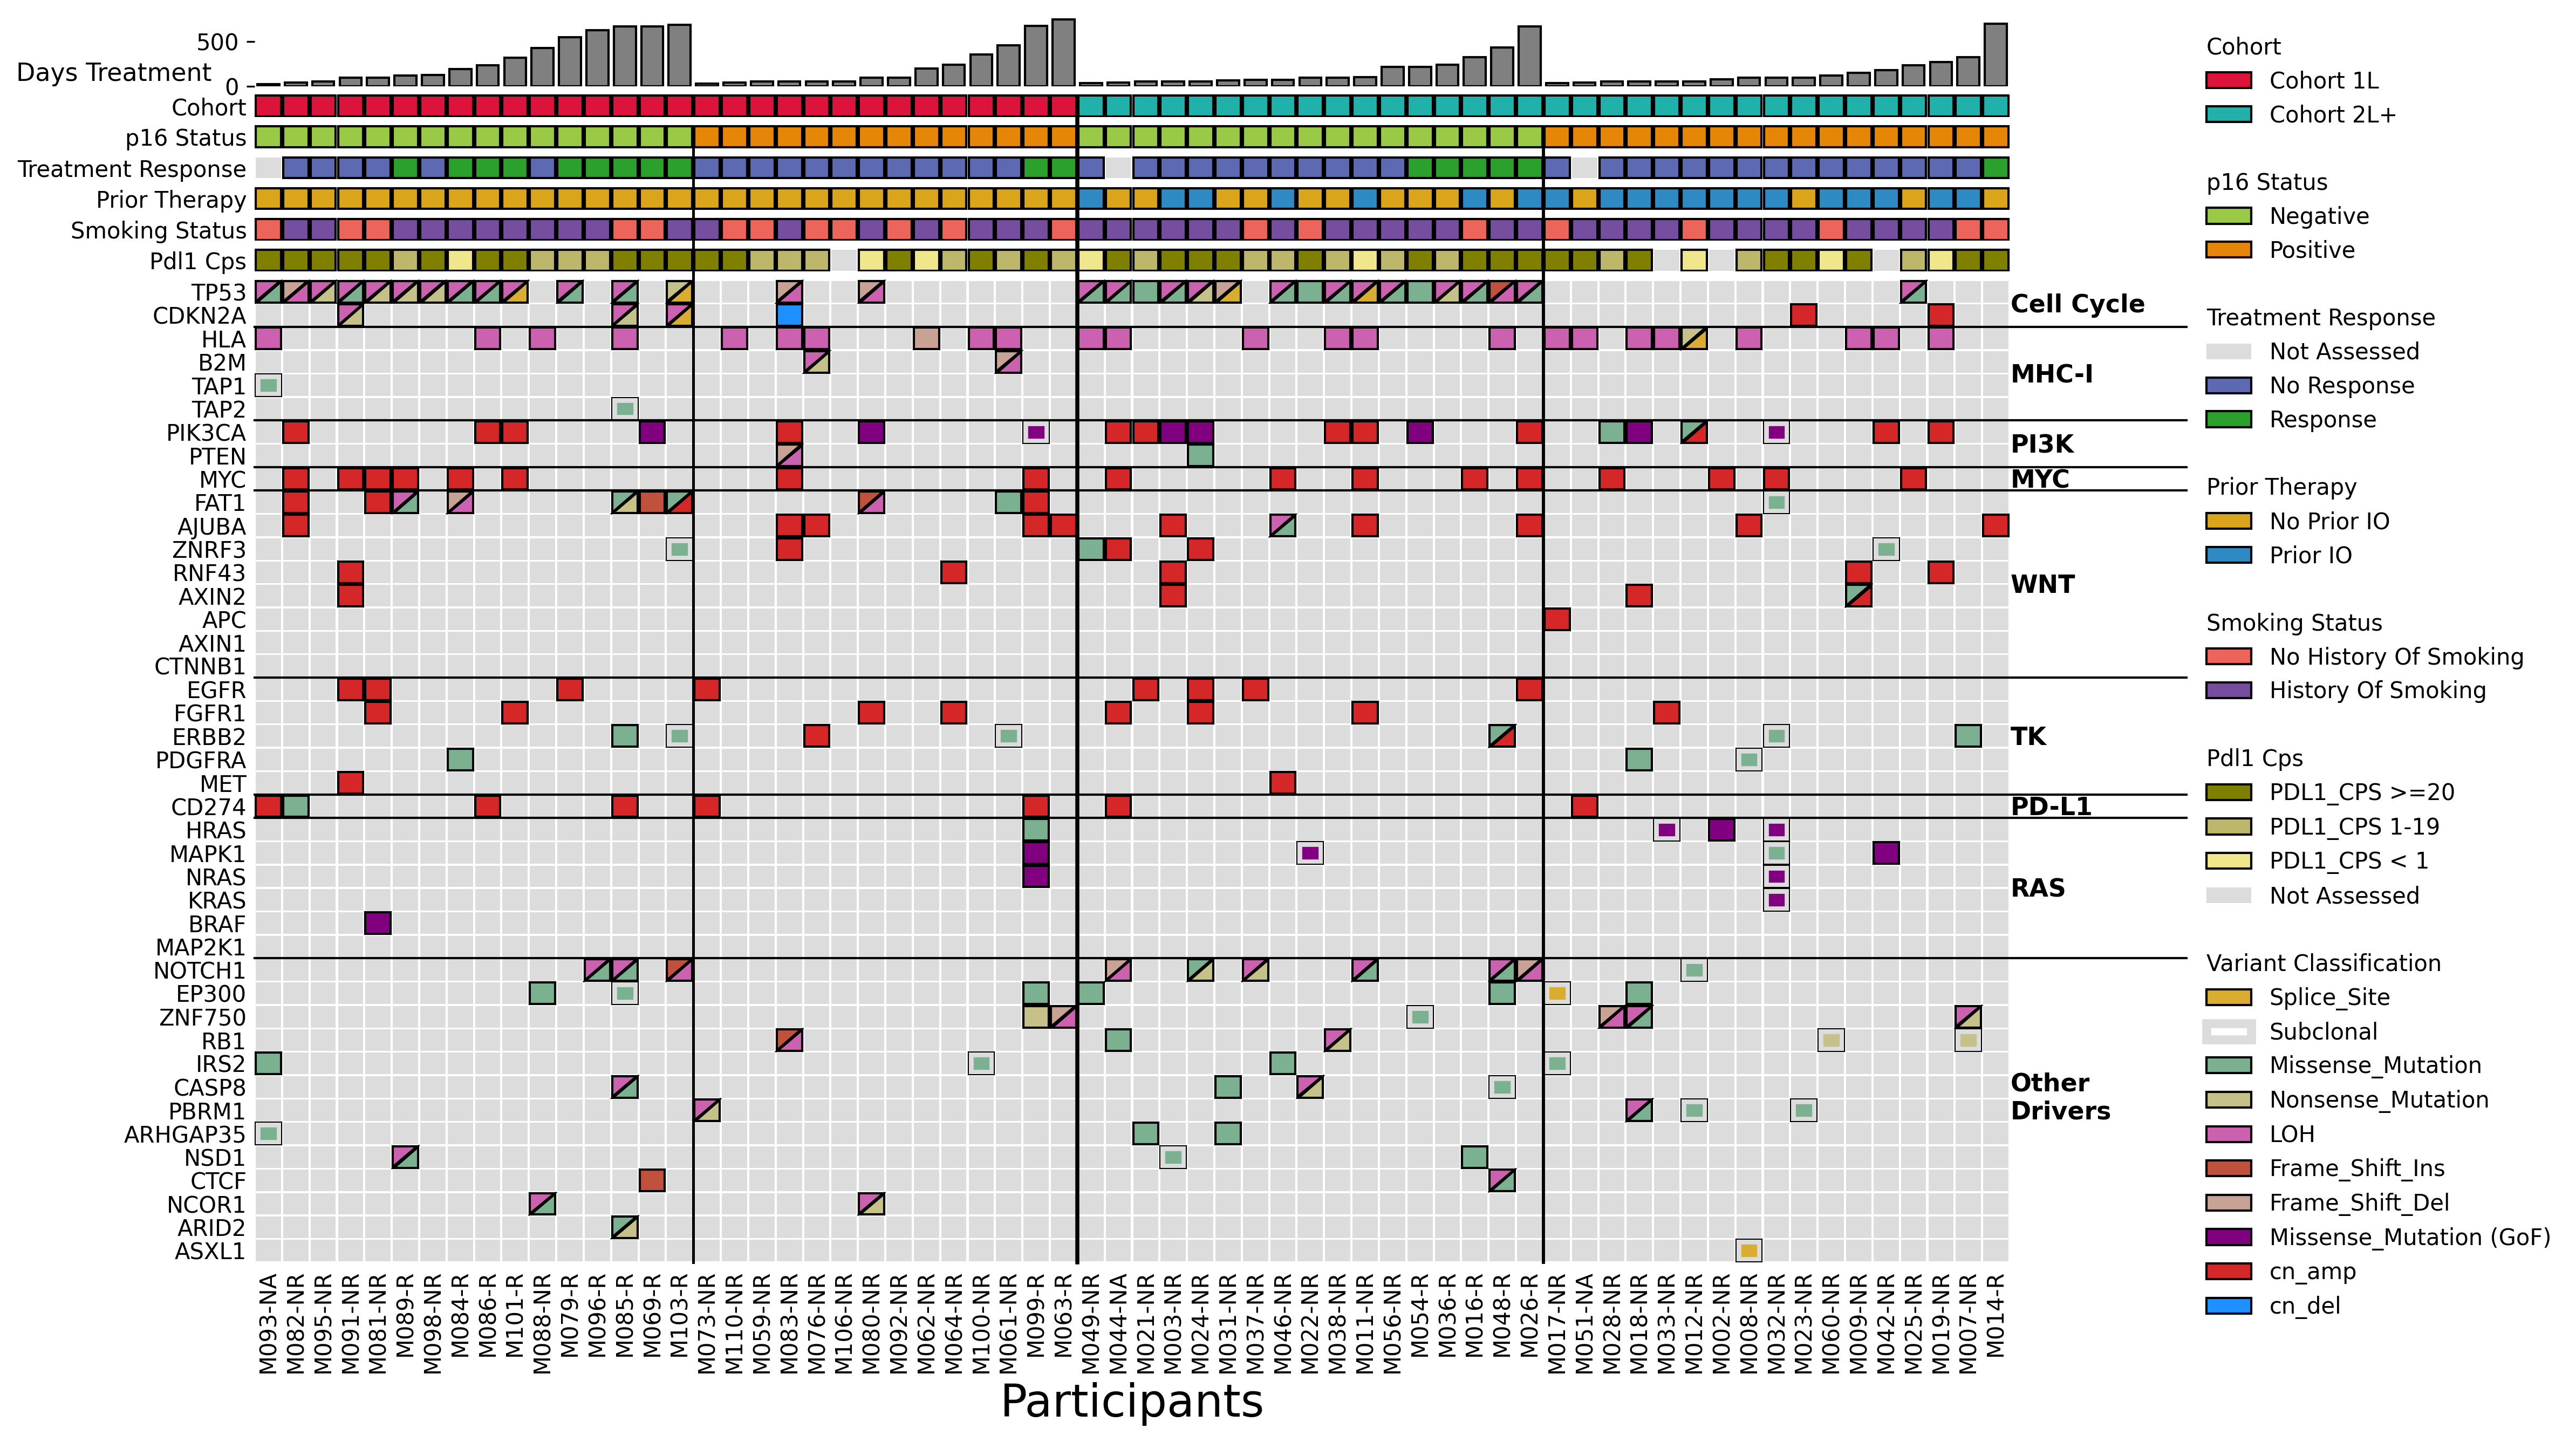

In [10]:
path_comut = comut.CoMut()

path_comut.samples = value_order

plot = pd.concat([plot_df[['sample', 'category', 'value', 'ccf_hat']], df_clonal]).drop_duplicates(subset=['sample', 'category', 'value'])
# removing subclonal events when there is already a clonal mutation in the gene
plot = plot[~((plot['category']=='PTEN')&(plot['sample']=='M083-NR')&(plot['value'].isin(['Subclonal', 'Missense_Mutation'])))]
plot = plot[~((plot['category']=='FAT1')&(plot['sample']=='M084-R')&(plot['value'].isin(['Subclonal', 'Nonsense_Mutation'])))]
plot = plot[~((plot['category']=='FAT1')&(plot['sample']=='M080-NR')&(plot['value'].isin(['Subclonal', 'Nonsense_Mutation', 'Missense_Mutation'])))]
plot = plot[~((plot['sample']=='M093-NA')&(plot['value']=='cn_del'))] # issue with one sample having low purity


path_comut.add_categorical_data(plot, name='Variant Classification', category_order=plot_genes, mapping=mappings['variant'], borders = ['Subclonal'],
                                priority=['Nonsense_Mutation', 'LOH', 'subclonal', 'cn_del', 'cn_amp', 'Frame_Shift_Del', 'Missense_Mutation', 'Splice_Site'])

for cat in ['Pdl1 Cps', 'Smoking Status', 'Prior Therapy', 'Treatment Response', 'p16 Status', 'Cohort']:    
    path_comut.add_categorical_data(utils.create_categorical_comut_df(plot_df, cat), name=cat, mapping=mappings['clinical']|mappings['Pdl1 Cps'])

bar_kwargs = {'width': 0.8, 'edgecolor': 'black'}
path_comut.add_bar_data(df_time[df_time['sample'].isin(comut_parts)], name='treatment_length', bar_kwargs=bar_kwargs, mapping={'Treatment Length':'grey'})

path_comut.plot_comut(figsize = (14,10), x_padding = 0.04, y_padding = 0.04, tri_padding = 0.03, hspace = 0.05, wspace=.17)

# vertical lines
path_comut.axes['Variant Classification'].set_zorder(50)
path_comut.axes['Variant Classification'].axvline(cohort_x, ls='-', c='black', lw=1.8, ymax = 1.185, clip_on=False)
path_comut.axes['Variant Classification'].axvline(cohort_a_hpv_x, ls='-', c='black', lw=1.2, ymax = 1.154, clip_on=False)
path_comut.axes['Variant Classification'].axvline(cohort_b_hpv_x, ls='-', c='black', lw=1.4, ymax = 1.154, clip_on=False)
    
# pathway lines
for hline in np.array(line_indices):
    path_comut.axes['Variant Classification'].axhline(hline, ls="-", c='black', xmin=0, xmax=1.1, clip_on=False, lw=1)

# pathway labels
for group, place in zip(path_texts, text_locs):
    path_comut.axes['Variant Classification'].annotate(text=group, xy=(path_comut.axes['Variant Classification'].get_xlim()[1], place-.08), annotation_clip=False, size=11, fontweight='demibold')

path_comut.axes['treatment_length'].set_ylabel('Days Treatment', rotation=0, size=11, loc='bottom', labelpad=80)
path_comut.axes['Variant Classification'].set(xlabel='Participants')
path_comut.add_unified_legend(ncols=1, bbox_to_anchor=(1.1, 1));